# Aging fibroblast subject to compressive force
---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import tifffile
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from itertools import combinations

import sys

sys.path.append("..")
from src.utils.io import get_file_list

scaler = StandardScaler()

In [2]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier, title):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12, 10))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title=title)
    ax.legend(loc="lower right")
    return fig, ax, classifier

In [3]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [4]:
def get_significant_metrics_by_fwer(pvalues, alpha):
    fwer_pvalues = pvalues/len(subset_all_features.columns)
    sign_idc = fwer_pvalues<alpha
    significant_features = np.array(subset_all_features.columns)[sign_idc]

    sign_fwer_features = dict(zip(significant_features, fwer_pvalues[sign_idc]))
    sign_fwer_features = {k: v for k, v in sorted(sign_fwer_features.items(), key=lambda item: item[1])}
    return sign_fwer_features

In [5]:
def ranksum_screen(data, labels, screen_idc = [0,1]):
    unique_labels = np.unique(labels)
    data = np.array(data)
    x = data[labels==unique_labels[screen_idc[0]],:]
    y = data[labels==unique_labels[screen_idc[1]],:]
    
    pvalues = []
    for i in range(x.shape[1]):
        pvalues.append(stats.ranksums(x[:,i], y[:,i])[1])
    return np.array(pvalues)

In [7]:
def find_markers(data):
    results = []
    samples = np.unique(data["sample"])
    i = 0
    for sample in samples:
        sample_results = {'sample':[], 'marker':[], 'fc':[], 'abs_delta_fc':[], 'pval':[]}
        for c in data.columns:
            if c == "sample":
                continue
            i += 1
            x = np.array(data.loc[data["sample"]== sample, c])
            y = np.array(data.loc[data["sample"]!= sample, c])
            x = np.array(x[x != np.nan]).astype(float)
            y = np.array(y[y != np.nan]).astype(float)
            
            pval = stats.ranksums(x, y)[1]
            fc = (np.mean(x)+1e-15)/(np.mean(y)+1e-15)
            sample_results["sample"].append(sample)
            sample_results["marker"].append(c)
            sample_results["fc"].append(fc)
            sample_results["abs_delta_fc"].append(abs(fc-1))
            sample_results["pval"].append(pval)
        sample_result = pd.DataFrame(sample_results)
        sample_result.pval= sample_result.pval.astype(float)
        sample_result = sample_result.sort_values('pval')
        results.append(sample_result)
    result = pd.concat(results)
    result["fwer_padj"] = result.pval / i
    return result

In [8]:
def compute_all_pairwise_comparisons_mw_test(data, feature):
    samples = list(np.unique(data["sample"]))
    combs = list(combinations(samples,2))
    results = []
    for comb in combs:
        x = data.loc[data["sample"]==comb[0], feature]
        y = data.loc[data["sample"]==comb[1], feature]

        x = np.array(x[x != np.nan])
        y = np.array(y[y != np.nan])
        pval = stats.ranksums(x, y)[1]
        results.append([comb[0], comb[1], pval, min(pval * len(comb),1)])
    results = pd.DataFrame(np.array(results), columns=["sample1", "sample2", "pval", "fwer_padj"])
    results.fwer_padj = results.fwer_padj.astype(float)
    results = results.sort_values("fwer_padj")
    return results

---

## 1. Preprocess imaging data

Before we can use the existing pipelines to derive the nuclear features, we first have to preprocess the data to combine the different channels for each image that are for now stored as individual files.

In [9]:
root_dir = "/home/paysan_d/Desktop/raj_aging_data/"
subdirs = [os.path.join(root_dir, o) for o in os.listdir(root_dir) 
                    if os.path.isdir(os.path.join(root_dir,o))]
subdirs

['/home/paysan_d/Desktop/raj_aging_data/young_l1_hp1_muT_combined',
 '/home/paysan_d/Desktop/raj_aging_data/old_c_hp1_muT_combined',
 '/home/paysan_d/Desktop/raj_aging_data/young_l2_hp1_muT_combined',
 '/home/paysan_d/Desktop/raj_aging_data/young_c_hp1_muT_combined',
 '/home/paysan_d/Desktop/raj_aging_data/old_l2_hp1_muT_combined',
 '/home/paysan_d/Desktop/raj_aging_data/old_l1_hp1_muT_combined']

In [10]:
def combine_and_store_multichannel_images(in_dir, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    file_list = get_file_list(in_dir)
    for i in np.arange(0, len(file_list), 4):
        channel_files = file_list[i:i+4]
        combined_image_name = os.path.split(channel_files[0])[1]
        combined_image_name = combined_image_name[:combined_image_name.index("_ch")]
        combined_image = []
        for channel_file in channel_files:
            combined_image.append(tifffile.imread(channel_file))
        combined_image = np.array(combined_image).transpose([1,0,2,3])
        save_path = os.path.join(out_dir, combined_image_name)
        tifffile.imsave(save_path+".tif", combined_image,imagej=True)
    

In [11]:
for d in subdirs:
    combine_and_store_multichannel_images(d, out_dir=d +"_combined")

ValueError: substring not found

---
## 2. Read in data

In the meantime we have run several pipelines and manual selection steps to segment the individual nuclei, filter out imaging and segmentation artifacts and compute characteristic features of the 2D max-z projected DAPI images and the multichannel images in 3D for the individual nuclei.

### 1.1. Young control data

In [13]:
root_dir = "../data/raj_aging_data/all_features/"

yc_features_2d = pd.read_csv(root_dir+"young_c_features_2d.csv", index_col=0)
yc_features_3d = pd.read_csv(root_dir+"young_c_features_3d.csv", index_col=0)
yc_features = yc_features_2d.join(yc_features_3d, rsuffix="_3d")

yc_features["sample"] = np.repeat("yc", len(yc_features))
yc_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_tubilin_int,skewness_tubilin_int,normalized_mean_tubilin_int,normalized_std_tubilin_int,normalized_q25_tubilin_int,normalized_q75_tubilin_int,normalized_median_tubilin_int,normalized_kurtosis_tubilin_int,normalized_skewness_tubilin_int,sample
TileScan 1_Position 2_RAW_0,0.007194,0.034746,311,0.103945,0.039349,0.033706,0.018324,12.630885,321,0.098052,...,5.402098,2.027078,0.226597,0.137914,0.0,0.149531,0.198897,5.402102,2.027077,yc
TileScan 1_Position 3_RAW_0,0.006718,0.032299,353,0.106286,0.036247,0.033706,0.015902,12.106423,334,0.155063,...,5.583291,1.992567,0.205682,0.128087,0.0,0.147886,0.177220,5.583290,1.992568,yc
TileScan 1_Position 4_RAW_0,0.008124,0.059907,312,0.356789,0.049563,0.033706,0.045517,15.315080,309,0.375000,...,10.292139,2.585631,0.227628,0.161975,0.0,0.165148,0.189359,10.292154,2.585633,yc
TileScan 1_Position 5_RAW_0,0.006400,0.034634,380,0.098052,0.038460,0.033706,0.018021,13.576487,353,0.123852,...,8.986751,2.601155,0.197737,0.141916,0.0,0.101415,0.158217,8.986753,2.601156,yc
TileScan 1_Position 6_RAW_0,0.007915,0.048373,325,0.195194,0.044535,0.037563,0.027821,15.988152,359,0.387426,...,5.978280,2.057812,0.257863,0.151780,0.0,0.142927,0.230046,5.978284,2.057813,yc


----

### 1.2. Young with compressive load 1 data

In [14]:
yl1_features_2d = pd.read_csv(root_dir+"young_l1_features_2d.csv", index_col=0)
yl1_features_3d = pd.read_csv(root_dir+"young_l1_features_3d.csv", index_col=0)
yl1_features = yl1_features_2d.join(yl1_features_3d, rsuffix="_3d")

yl1_features["sample"] = np.repeat("yl1", len(yl1_features))
yl1_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_tubilin_int,skewness_tubilin_int,normalized_mean_tubilin_int,normalized_std_tubilin_int,normalized_q25_tubilin_int,normalized_q75_tubilin_int,normalized_median_tubilin_int,normalized_kurtosis_tubilin_int,normalized_skewness_tubilin_int,sample
TileScan 1_Position 2_RAW_0,0.007826,0.033853,290,0.089717,0.040019,0.037563,0.017224,11.605561,290,0.089717,...,17.650919,3.363802,0.234943,0.198482,0.011403,0.137419,0.182414,17.650903,3.363802,yl1
TileScan 1_Position 3_RAW_0,0.006989,0.033354,325,0.103945,0.039263,0.036495,0.017325,12.289266,313,0.089717,...,9.803704,2.520067,0.216661,0.142515,0.000000,0.138780,0.181740,9.803704,2.520067,yl1
TileScan 1_Position 4_RAW_0,0.008799,0.063546,314,0.270004,0.055802,0.037563,0.042022,21.595347,387,0.281729,...,12.953469,2.891234,0.217036,0.162217,0.000000,0.117959,0.170009,12.953476,2.891234,yl1
TileScan 1_Position 6_RAW_0,0.007065,0.049362,362,0.208557,0.045480,0.036495,0.029163,17.646060,388,0.260537,...,10.624703,2.471692,0.208617,0.120451,0.006906,0.129768,0.183081,10.624701,2.471692,yl1
TileScan 1_Position 7_RAW_0,0.006080,0.042289,397,0.107489,0.043441,0.037563,0.020562,17.376412,400,0.158717,...,15.682600,3.332818,0.189456,0.131221,0.000000,0.092222,0.154863,15.682589,3.332816,yl1


---
### 1.3. Young with compressive load 2 data

In [15]:
yl2_features_2d = pd.read_csv(root_dir+"young_l2_features_2d.csv", index_col=0)
yl2_features_3d = pd.read_csv(root_dir+"young_l2_features_3d.csv", index_col=0)
yl2_features = yl2_features_2d.join(yl2_features_3d, rsuffix="_3d")

yl2_features["sample"] = np.repeat("yl2", len(yl2_features))
yl2_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_tubilin_int,skewness_tubilin_int,normalized_mean_tubilin_int,normalized_std_tubilin_int,normalized_q25_tubilin_int,normalized_q75_tubilin_int,normalized_median_tubilin_int,normalized_kurtosis_tubilin_int,normalized_skewness_tubilin_int,sample
TileScan 1_Position 1_RAW_0,0.007998,0.043430,280,0.174355,0.048775,0.037563,0.028050,13.169223,270,0.188638,...,43.002524,5.224817,0.249989,0.260486,0.000000,0.071922,0.161101,43.002515,5.224818,yl2
TileScan 1_Position 1_RAW_1,0.007937,0.042639,284,0.220481,0.045599,0.037563,0.025284,13.360520,293,0.281729,...,29.085782,4.383156,0.236399,0.217124,0.013552,0.091887,0.165705,29.085761,4.383157,yl2
TileScan 1_Position 2_RAW_0,0.006607,0.038136,345,0.098052,0.041624,0.037563,0.018789,14.818038,356,0.127919,...,4.434810,1.664618,0.215325,0.110715,0.000000,0.152573,0.196235,4.434821,1.664620,yl2
TileScan 1_Position 3_RAW_0,0.001534,0.074570,394,0.387426,0.055230,0.037563,0.052748,21.649988,392,0.459029,...,8.457923,2.489790,0.191597,0.141666,0.000000,0.119662,0.153537,8.457931,2.489792,yl2
TileScan 1_Position 4_RAW_0,0.007407,0.031740,382,0.102207,0.037869,0.033706,0.016774,11.512044,304,0.094194,...,153.276558,9.523869,0.122310,0.233817,0.000000,0.050994,0.054460,153.276407,9.523868,yl2


---
### 1.4. Old control data

In [16]:
oc_features_2d = pd.read_csv(root_dir+"old_c_features_2d.csv", index_col=0)
oc_features_3d = pd.read_csv(root_dir+"old_c_features_3d.csv", index_col=0)
oc_features = oc_features_2d.join(oc_features_3d, rsuffix="_3d")

oc_features["sample"] = np.repeat("oc", len(oc_features))
oc_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_tubilin_int,skewness_tubilin_int,normalized_mean_tubilin_int,normalized_std_tubilin_int,normalized_q25_tubilin_int,normalized_q75_tubilin_int,normalized_median_tubilin_int,normalized_kurtosis_tubilin_int,normalized_skewness_tubilin_int,sample
TileScan 1_Position 1_RAW_0,0.002171,0.113553,270,0.459029,0.088050,0.067891,0.066817,34.075486,387,0.387426,...,12.394060,2.820663,0.286642,0.186019,0.006178,0.136186,0.243418,12.394075,2.820665,oc
TileScan 1_Position 2_RAW_0,0.008578,0.056015,235,0.220481,0.054494,0.041517,0.031549,15.530737,285,0.212778,...,7.735252,2.267642,0.325417,0.212089,0.000000,0.206395,0.277395,7.735249,2.267641,oc
TileScan 1_Position 3_RAW_0,0.009524,0.074936,240,0.297883,0.064961,0.052555,0.048013,21.567020,332,0.361302,...,16.479397,3.348816,0.255639,0.211246,0.012822,0.118979,0.191182,16.479368,3.348812,oc
TileScan 1_Position 4_RAW_0,0.006286,0.082294,239,0.296349,0.068991,0.054669,0.051768,21.318152,309,0.320377,...,10.582326,2.671736,0.286079,0.210749,0.000000,0.165317,0.224743,10.582340,2.671739,oc
TileScan 1_Position 5_RAW_0,0.008329,0.045364,266,0.128911,0.046712,0.037563,0.023180,14.013693,300,0.160425,...,13.104982,2.925796,0.291149,0.206282,0.003526,0.134771,0.238530,13.104993,2.925799,oc


---
### 1.5. Old with compressive load 1 data

In [17]:
ol1_features_2d = pd.read_csv(root_dir+"old_l1_features_2d.csv", index_col=0)
ol1_features_3d = pd.read_csv(root_dir+"old_l1_features_3d.csv", index_col=0)
ol1_features = ol1_features_2d.join(ol1_features_3d, rsuffix="_3d")

ol1_features["sample"] = np.repeat("ol1", len(ol1_features))
ol1_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_tubilin_int,skewness_tubilin_int,normalized_mean_tubilin_int,normalized_std_tubilin_int,normalized_q25_tubilin_int,normalized_q75_tubilin_int,normalized_median_tubilin_int,normalized_kurtosis_tubilin_int,normalized_skewness_tubilin_int,sample
TileScan 1_Position 1_RAW_0,0.006994,0.039056,314,0.121212,0.042255,0.037563,0.020281,14.408822,341,0.127626,...,6.841818,2.250242,0.234222,0.133456,0.006525,0.126346,0.204231,6.841810,2.250240,ol1
TileScan 1_Position 2_RAW_0,0.007705,0.047161,293,0.222027,0.046155,0.037563,0.026561,13.615633,295,0.309017,...,8.431477,2.330081,0.297794,0.194258,0.000000,0.176410,0.253603,8.431473,2.330081,ol1
TileScan 1_Position 3_RAW_0,0.007271,0.041465,296,0.136772,0.044412,0.037563,0.022699,14.256284,321,0.155063,...,19.751049,3.263737,0.233628,0.150607,0.008829,0.107844,0.200804,19.751075,3.263738,ol1
TileScan 1_Position 4_RAW_0,0.004458,0.073852,325,0.414214,0.058522,0.040807,0.046938,23.818611,407,0.331613,...,5.190338,1.992793,0.243875,0.111163,0.000000,0.115789,0.225190,5.190339,1.992795,ol1
TileScan 1_Position 5_RAW_0,0.006569,0.055947,285,0.285714,0.052610,0.042304,0.035766,17.624249,335,0.212778,...,29.001488,4.361053,0.225391,0.206987,0.000000,0.087645,0.162376,29.001474,4.361053,ol1


---

### 1.6. Old with compressive load 2 data

In [18]:
ol2_features_2d = pd.read_csv(root_dir+"old_l2_features_2d.csv", index_col=0)
ol2_features_3d = pd.read_csv(root_dir+"old_l2_features_3d.csv", index_col=0)
ol2_features = ol2_features_2d.join(ol2_features_3d, rsuffix="_3d")

ol2_features["sample"] = np.repeat("ol2", len(ol2_features))
ol2_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,kurtosis_tubilin_int,skewness_tubilin_int,normalized_mean_tubilin_int,normalized_std_tubilin_int,normalized_q25_tubilin_int,normalized_q75_tubilin_int,normalized_median_tubilin_int,normalized_kurtosis_tubilin_int,normalized_skewness_tubilin_int,sample
TileScan 1_Position 1_RAW_0,0.006027,0.045235,383,0.166243,0.046503,0.037563,0.025208,17.205946,370,0.234468,...,32.216708,4.280244,0.162621,0.133226,0.000633,0.089691,0.129472,32.216720,4.280245,ol2
TileScan 1_Position 3_RAW_0,0.010269,0.077625,314,0.472136,0.065566,0.053540,0.052240,28.914750,441,0.309017,...,11.180920,2.714844,0.211166,0.163694,0.000000,0.116952,0.173651,11.180928,2.714845,ol2
TileScan 1_Position 5_RAW_0,0.006298,0.047564,341,0.132993,0.047515,0.037563,0.023090,18.673502,393,0.158717,...,12.702436,2.754741,0.216223,0.129610,0.016671,0.141838,0.183824,12.702428,2.754741,ol2
TileScan 1_Position 6_RAW_0,0.008839,0.068258,330,0.387426,0.060846,0.048074,0.047910,25.677216,422,0.387426,...,7.158463,2.225276,0.200583,0.132877,0.000000,0.138361,0.169312,7.158472,2.225276,ol2
TileScan 1_Position 7_RAW_0,0.006606,0.052171,285,0.170674,0.049519,0.040807,0.027945,18.817359,380,0.181589,...,5.110311,1.801705,0.231690,0.126655,0.024198,0.173034,0.206041,5.110311,1.801704,ol2


---

## 2. Data preprocessing

We will now preprocess the data for the downstream analyses.

In [19]:
all_features = yc_features.append(yl1_features).append(yl2_features).append(oc_features).append(ol1_features).append(ol2_features)
all_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,median_tubilin_int,kurtosis_tubilin_int,skewness_tubilin_int,normalized_mean_tubilin_int,normalized_std_tubilin_int,normalized_q25_tubilin_int,normalized_q75_tubilin_int,normalized_median_tubilin_int,normalized_kurtosis_tubilin_int,normalized_skewness_tubilin_int
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.007166,0.052438,313.719665,0.205100,0.050471,0.040487,0.031276,17.684610,343.686192,0.211643,...,3175.778243,15.138509,2.883700,0.230461,0.161385,0.005145,0.135030,0.189525,15.138508,2.883700
std,0.001838,0.019810,55.883816,0.105089,0.013458,0.010192,0.014816,7.552992,53.830010,0.096927,...,1557.155899,16.752692,1.136006,0.042316,0.034661,0.007892,0.035399,0.043598,16.752685,1.136005
min,-0.006699,0.028699,190.000000,0.071429,0.035923,0.033706,0.012568,9.032605,227.000000,0.067891,...,220.000000,0.905415,1.020784,0.068559,0.080754,0.000000,0.026738,0.026316,0.905418,1.020785
25%,0.006597,0.037946,280.000000,0.121212,0.041688,0.037563,0.020090,13.440087,306.500000,0.127919,...,2076.000000,7.533219,2.250165,0.205596,0.136006,0.000000,0.112299,0.161498,7.533217,2.250164
50%,0.007272,0.047816,311.000000,0.160907,0.046902,0.037563,0.025997,15.554564,338.000000,0.188638,...,2959.000000,10.730739,2.647039,0.231426,0.159750,0.000000,0.134796,0.191182,10.730765,2.647042
75%,0.008054,0.061148,341.500000,0.275982,0.054862,0.040807,0.037714,20.410965,373.000000,0.281729,...,4004.500000,16.777261,3.278401,0.256493,0.183621,0.009008,0.157198,0.217363,16.777254,3.278401
max,0.010729,0.170786,602.000000,0.585786,0.154601,0.141508,0.093604,92.605910,599.000000,0.472136,...,8730.000000,153.276558,9.523869,0.358462,0.281306,0.042448,0.243249,0.312320,153.276407,9.523868


### 2.1. Remove constant and NA samples

In [20]:
# Remove constant features for control data
cleaned_all_features = all_features.loc[:, (all_features != all_features.iloc[0]).any()]
cleaned_all_features = cleaned_all_features.dropna(axis=1, how='all')
# Remove rows with missing entries in the control data
cleaned_all_features = cleaned_all_features.dropna(axis=0)
print("{} rows and {} columns were dropped.".format(str(len(all_features)-len(cleaned_all_features)), 
                                                                         str(len(all_features.columns)-len(cleaned_all_features.columns))))

0 rows and 6 columns were dropped.


### 2.2. Control batch effects

To check if there are significant batch effects even before further dimensionality reduction, we will plot some general morphological features that should constant between technical replicates.

In [21]:
Counter(cleaned_all_features["sample"])

Counter({'yc': 39, 'yl1': 40, 'yl2': 41, 'oc': 31, 'ol1': 45, 'ol2': 43})

#### Volume

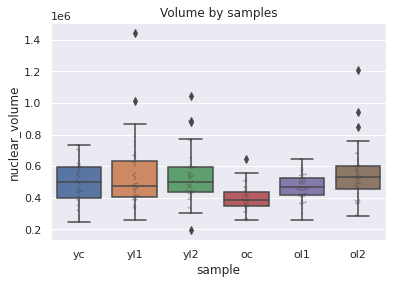

In [99]:
ax = sns.boxplot(x="sample", y="nuclear_volume", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="nuclear_volume", data=cleaned_all_features, color=".25", alpha=0.4, size=2)


plt.title("Volume by samples")
plt.show()

In [23]:
compute_all_pairwise_comparisons_mw_test(cleaned_all_features, "nuclear_volume")

,sample1,sample2,pval,fwer_padj
1,oc,ol2,8.02570953808693e-06,0.000016
4,oc,yl2,3.0724918939487566e-05,0.000061
0,oc,ol1,0.0005163838576920712,0.001033
3,oc,yl1,0.0006532566203859166,0.001307
2,oc,yc,0.0015625825677694977,0.003125
5,ol1,ol2,0.015135719330435006,0.030271
8,ol1,yl2,0.10873655438300012,0.217473
9,ol2,yc,0.2671862979846249,0.534373
6,ol1,yc,0.33947890807294845,0.678958
7,ol1,yl1,0.38822440490753385,0.776449


#### Area (max-z projection)

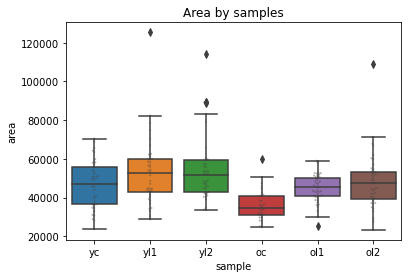

In [24]:
ax = sns.boxplot(x="sample", y="area", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="area", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
x1, x2 = 0, 1
plt.title("Area by samples")
plt.show()

In [25]:
compute_all_pairwise_comparisons_mw_test(cleaned_all_features, "area")

,sample1,sample2,pval,fwer_padj
4,oc,yl2,2.276066023048613e-08,4.552132e-08
3,oc,yl1,9.959077467330564e-07,1.991815e-06
0,oc,ol1,6.880220769138354e-06,1.376044e-05
1,oc,ol2,2.919637376881136e-05,5.839275e-05
2,oc,yc,0.0002647336586742546,5.294673e-04
8,ol1,yl2,0.002584633659010801,5.169267e-03
7,ol1,yl1,0.010943333434548614,2.188667e-02
13,yc,yl2,0.07417496053392023,1.483499e-01
11,ol2,yl2,0.07716994451261842,1.543399e-01
12,yc,yl1,0.14132600304255616,2.826520e-01


#### Feret distance

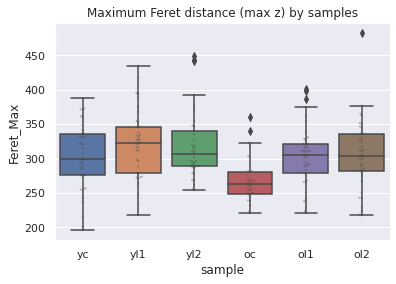

In [105]:
ax = sns.boxplot(x="sample", y="Feret_Max", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="Feret_Max", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
x1, x2 = 0, 1
plt.title("Maximum Feret distance (max z) by samples")
plt.show()

In [103]:
set(cleaned_all_features.columns)

{'ASM_1',
 'ASM_20',
 'ASM_5',
 'A_R',
 'Area_bbArea',
 'Avg_Curvature',
 'Avg_Radius',
 'Avg_neg_Curvature',
 'Avg_posi_Curvature',
 'Center_Mismatch',
 'Concavity',
 'Contrast_1',
 'Contrast_20',
 'Contrast_5',
 'D25_Radius',
 'D75_Radius',
 'Entropy',
 'Feret_Max',
 'Frac_Peri_w_neg_curvature',
 'Frac_Peri_w_polarity_changes',
 'Frac_Peri_w_posi_curvature',
 'HC_area_EC_area',
 'HC_area_Nuc_area',
 'HC_content_DNA_content',
 'HC_content_EC_content',
 'I80_I20',
 'Int_Max',
 'Int_Mean',
 'Int_Median',
 'Int_Min',
 'Int_Mode',
 'Int_SD',
 'Int_d25',
 'Int_d75',
 'Len_neg_Curvature',
 'Len_posi_Curvature',
 'Max_Calliper',
 'Max_Radius',
 'Max_neg_Curvature',
 'Max_posi_Curvature',
 'Med_Radius',
 'Med_neg_Curvature',
 'Med_posi_Curvature',
 'Min_Calliper',
 'Min_Radius',
 'Mode_Radius',
 'Shape_Factor',
 'Smallest_largest_Calliper',
 'Solidity',
 'Std_Curvature',
 'Std_Radius',
 'Std_neg_Curvature',
 'Std_posi_Curvature',
 'Sum_neg_Curvature',
 'Sum_posi_Curvature',
 'area',
 'bbox-0'

In [106]:
compute_all_pairwise_comparisons_mw_test(cleaned_all_features, "Feret_Max")

,sample1,sample2,pval,fwer_padj
4,oc,yl2,1.4627464926567117e-06,0.000003
3,oc,yl1,6.487018949803605e-06,0.000013
1,oc,ol2,0.0002584215909191579,0.000517
0,oc,ol1,0.0003327442695574665,0.000665
2,oc,yc,0.001172167685077475,0.002344
7,ol1,yl1,0.08440431830327688,0.168809
12,yc,yl1,0.20942675696103719,0.418854
10,ol2,yl1,0.22547416113717633,0.450948
13,yc,yl2,0.37327264231448254,0.746545
8,ol1,yl2,0.39921774788962394,0.798435


#### Median radius (max - z)

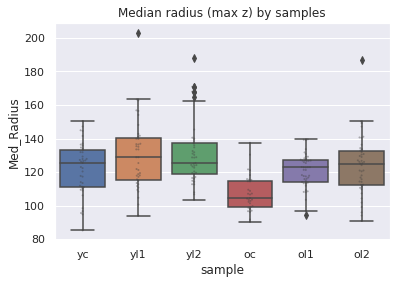

In [107]:
ax = sns.boxplot(x="sample", y="Med_Radius", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="Med_Radius", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
x1, x2 = 0, 1
plt.title("Median radius (max z) by samples")
plt.show()

In [108]:
compute_all_pairwise_comparisons_mw_test(cleaned_all_features, "Med_Radius")

,sample1,sample2,pval,fwer_padj
4,oc,yl2,1.8690216320713567e-08,3.738043e-08
3,oc,yl1,4.309459570061008e-07,8.618919e-07
0,oc,ol1,3.225613391461644e-06,6.451227e-06
1,oc,ol2,2.6508519711933077e-05,5.301704e-05
2,oc,yc,0.00011880977399964043,2.376195e-04
8,ol1,yl2,0.013566817092297016,2.713363e-02
7,ol1,yl1,0.03168991411679273,6.337983e-02
13,yc,yl2,0.10076629127053231,2.015326e-01
12,yc,yl1,0.1099658837771451,2.199318e-01
10,ol2,yl1,0.13983860898319286,2.796772e-01


#### Median intensity in the nucleus (max z-projection)

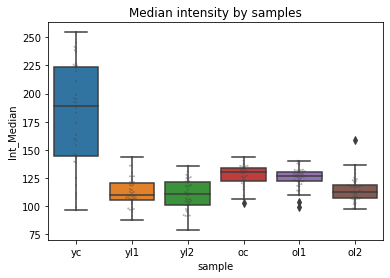

In [26]:
ax = sns.boxplot(x="sample", y="Int_Median", data=cleaned_all_features)
ax = sns.swarmplot(x="sample", y="Int_Median", data=cleaned_all_features, color=".25", alpha=0.4, size=2)
x1, x2 = 0, 1
plt.title("Median intensity by samples")
plt.show()

In [27]:
compute_all_pairwise_comparisons_mw_test(cleaned_all_features, "Int_Median")

,sample1,sample2,pval,fwer_padj
13,yc,yl2,2.9784116858148194e-10,5.956823e-10
12,yc,yl1,1.1333038538328338e-09,2.266608e-09
9,ol2,yc,2.0535852178553688e-09,4.107170e-09
8,ol1,yl2,3.7253212635557816e-08,7.450643e-08
6,ol1,yc,1.1258278764070646e-07,2.251656e-07
5,ol1,ol2,2.4313566368116403e-07,4.862713e-07
4,oc,yl2,2.660117551066473e-07,5.320235e-07
7,ol1,yl1,7.161259425870084e-07,1.432252e-06
2,oc,yc,1.6311848161856852e-06,3.262370e-06
1,oc,ol2,2.399589800718038e-06,4.799180e-06


### 2.2. Remove highly correlated features


In [76]:
# Maintain features that have at most a Pearson correlation of 0.7
threshold = 0.70
sample_labels = np.array(cleaned_all_features["sample"])
# Get correlation structure
cleaned_all_features_corr_matrix = cleaned_all_features.corr().abs()
upper = cleaned_all_features_corr_matrix.where(np.triu(np.ones(cleaned_all_features_corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > threshold)] + ["label"] +["bbox-0","bbox-1", "bbox-2", "bbox-3"] + ["sample"]
len(to_drop)

232

We drop 229 of the features that show a high autocorrelation (larger than 0.7) plus 3 that are artifacts from the segmentation.

In [77]:
subset_all_features = cleaned_all_features.drop(to_drop, axis=1)
subset_all_features_w_sample =subset_all_features.copy()
subset_all_features_w_sample["sample"] = sample_labels
subset_all_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,width_prominant_positive_curvature,width_prominant_negative_curvature,Min_Calliper,Int_Min,Int_Max,Entropy,I80_I20,...,kurtosis_dapi_int,rel_hp1_int,min_hp1_int,q75_hp1_int,kurtosis_hp1_int,rel_actin_int,kurtosis_actin_int,rel_tubilin_int,min_tubilin_int,kurtosis_tubilin_int
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.007166,0.052438,313.719665,7.196173,6.892594,197.903766,36.341412,254.818149,10.679396,1.507352,...,2.554592,10582.269161,6.355649,4699.622385,4.805272,4264.830095,11.031694,3848.308188,49.995816,15.138509
std,0.001838,0.019810,55.883816,0.903778,0.703941,37.511723,9.765334,2.308236,0.986602,0.105929,...,1.329744,3268.260357,40.683590,1802.290651,2.137921,2532.144097,7.490145,1803.540689,120.149819,16.752692
min,-0.006699,0.028699,190.000000,5.211934,5.748469,127.000000,17.701080,220.336884,6.246875,1.259216,...,-0.238319,2875.024892,0.000000,1133.000000,0.559661,743.829761,1.869888,494.090675,0.000000,0.905415
25%,0.006597,0.037946,280.000000,6.633670,6.435773,168.500000,29.020374,255.000000,10.381744,1.441987,...,1.659761,8270.982553,0.000000,3398.500000,3.526243,2438.976495,6.021455,2560.623790,0.000000,7.533219
50%,0.007272,0.047816,311.000000,7.137995,6.825424,196.000000,34.259941,255.000000,10.881271,1.494727,...,2.436403,10233.047495,0.000000,4232.000000,4.588508,3555.057619,9.212857,3616.918386,0.000000,10.730739
75%,0.008054,0.061148,341.500000,7.557895,7.118181,219.500000,41.451040,255.000000,11.280509,1.562119,...,3.266070,13005.881485,0.000000,5733.500000,5.844826,5551.483411,14.166169,4906.412239,50.000000,16.777261
max,0.010729,0.170786,602.000000,11.765948,11.848432,384.000000,66.216164,255.000000,12.159001,1.883848,...,12.902692,20652.914619,497.000000,14651.000000,18.956831,13080.755127,67.985621,10533.904534,1155.000000,153.276558


In [78]:
np.unique(subset_all_features.columns)

array(['Avg_Curvature', 'Center_Mismatch', 'Contrast_1', 'Entropy',
       'Frac_Peri_w_polarity_changes', 'Frac_Peri_w_posi_curvature',
       'I80_I20', 'Int_Max', 'Int_Min', 'Min_Calliper', 'Std_Curvature',
       'centroid-1', 'kurtosis_actin_int', 'kurtosis_dapi_int',
       'kurtosis_hp1_int', 'kurtosis_tubilin_int', 'min_hp1_int',
       'min_tubilin_int', 'moments_central-0-1', 'moments_central-1-0',
       'moments_hu-6', 'nPolarity_changes', 'orientation', 'q25_dapi_int',
       'q75_hp1_int', 'rel_actin_int', 'rel_hc_volume', 'rel_hp1_int',
       'rel_tubilin_int', 'weighted_moments_central-0-1',
       'weighted_moments_central-0-3', 'weighted_moments_central-1-0',
       'weighted_moments_central-2-1', 'weighted_moments_hu-2',
       'weighted_moments_hu-3', 'weighted_moments_hu-6',
       'weighted_moments_normalized-0-2',
       'weighted_moments_normalized-0-3',
       'weighted_moments_normalized-1-2',
       'weighted_moments_normalized-2-0',
       'weighted_moments

In [79]:
Counter(sample_labels)

Counter({'yc': 39, 'yl1': 40, 'yl2': 41, 'oc': 31, 'ol1': 45, 'ol2': 43})

In [80]:
sample_changes = list(Counter(sample_labels).values())

---

## 3. Data visualization

We will now visualize the cleaned data that consists of 52 features after our filtering and 302 samples of the control conditiona nd 185 samples of the treatment condition.

### 3.1. tSNE visualization

In [81]:
random.seed(1234)
tsne = TSNE(n_components=2, perplexity=30, random_state=1234)
scaled_subset_all_features = StandardScaler().fit_transform(subset_all_features)
embedded_subset_features = tsne.fit_transform(scaled_subset_all_features)

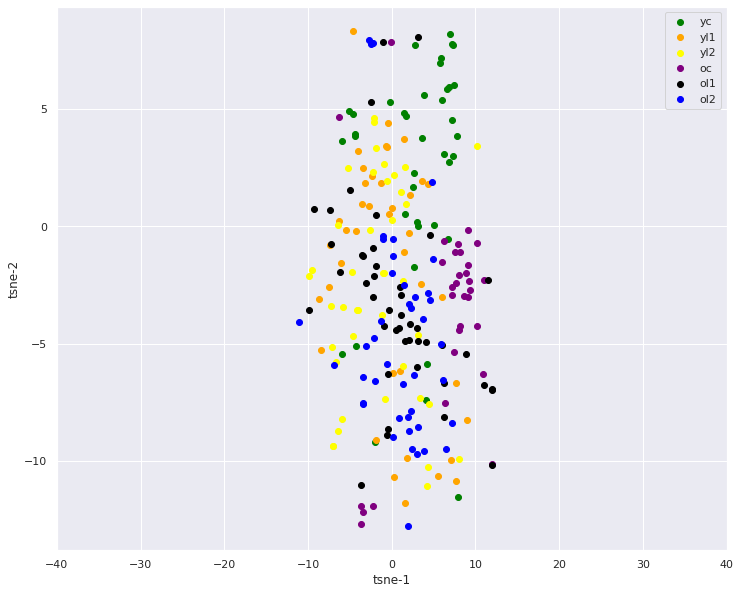

In [82]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(111)

x = embedded_subset_features[:,0]
y = embedded_subset_features[:,1]
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
colors = ["green", "orange", "yellow", "purple", "black", "blue", "red"]
j = 0
for i in range(len(sample_changes)):
    end = j + sample_changes[i]
    scatter = ax.scatter(x[j:end], y[j:end], c=colors[i], label=list(Counter(sample_labels).keys())[i])
    j = end
ax.set_xlim([-40,40])
ax.legend()
plt.show()

### 3.2. PCA visualization

In [83]:
pca = PCA(n_components=2, random_state=1234)
embedded_subset_features = pca.fit_transform(scaled_subset_all_features)
expl_var_ratio = pca.explained_variance_ratio_

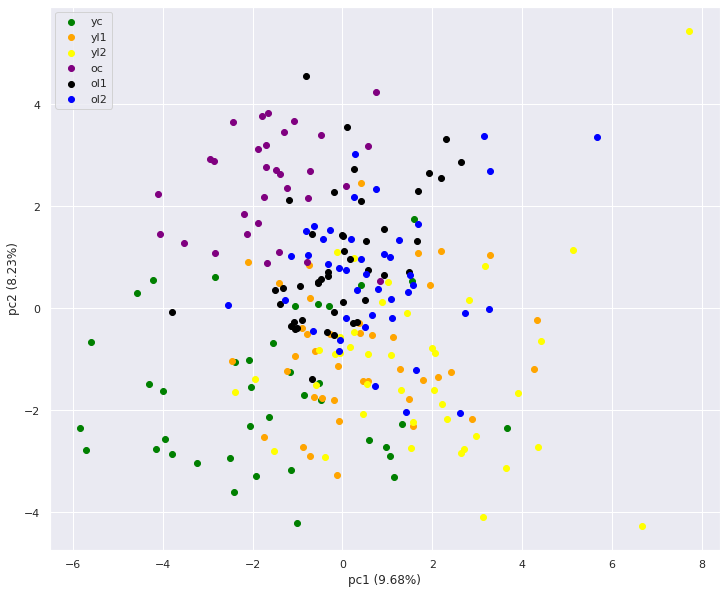

In [84]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(111)

x = embedded_subset_features[:,0]
y = embedded_subset_features[:,1]
ax.set_xlabel("pc1 ({}%)".format(np.round(expl_var_ratio[0]*100,2)))
ax.set_ylabel("pc2 ({}%)".format(np.round(expl_var_ratio[1]*100,2)))

colors = ["green", "orange", "yellow", "purple", "black", "blue", "red"]
j = 0
for i in range(len(sample_changes)):
    end = j + sample_changes[i]
    scatter = ax.scatter(x[j:end], y[j:end], c=colors[i], label=list(Counter(sample_labels).keys())[i])
    j = end
ax.legend()
plt.show()

## 4. Differences between the two conditions

We will now assess how dissimilar the treatment and the control condition samples are.

### 4.1. Random Forest classification

We fit a RandomForest classifier to see how well this algorithm often used as a baseline approach can separate the treatment from the control samples and in particular which features are most valuable for distinguishing those.

To this end, we first perform 10-fold stratified cross-validation to separate between the different samples and assess the accuracy and balanced accuracy of the classifier.

#### 4.1.1. Accuracy & balanced accuracy

In [85]:
rfc = RFC(n_estimators=100, random_state=1234, n_jobs=5, class_weight="balanced")
cv_results = cross_validate(rfc, scaled_subset_all_features, sample_labels, cv=10, scoring=["accuracy", "balanced_accuracy"])

In [86]:
cv_results = pd.DataFrame(cv_results)
cv_results.describe()

,fit_time,score_time,test_accuracy,test_balanced_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.116547,0.029188,0.766123,0.773611
std,0.014124,0.003694,0.073147,0.073449
min,0.088476,0.021493,0.666667,0.675000
25%,0.114276,0.027556,0.708333,0.718750
50%,0.115427,0.029600,0.750000,0.759722
75%,0.125403,0.032224,0.822917,0.822917
max,0.139777,0.032985,0.875000,0.891667


We see that we get an average accuracy of roughly 78.89% and a balanced accuracy of 76.86%. The difference can be explained by the fact that our model seems to perform worse on some minority classes.

#### 4.1.2. Individual ROC curves

Next, we turn the multi-class classification problem into several binary classification problems basically fitting one RFC classifier for a certain class vs the rest.
Below we plot the resulting ROC curves for a 10-fold stratified cross-validation approach.

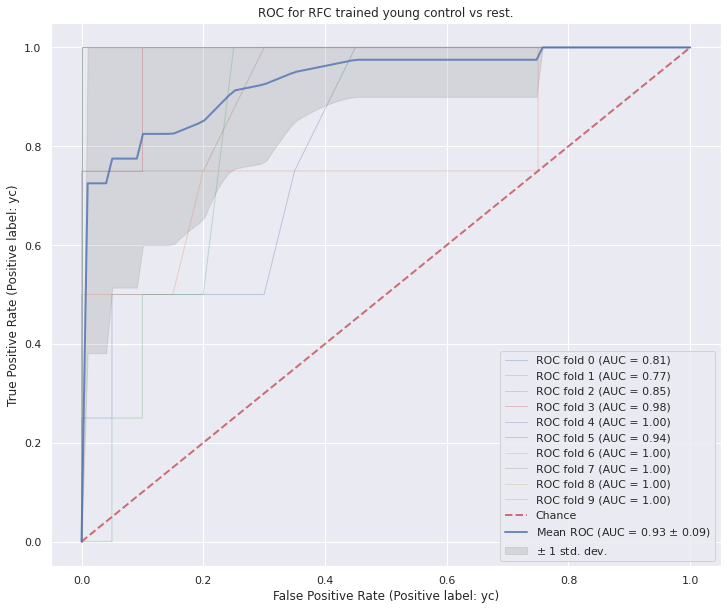

In [87]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "yc"] = "yc"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained young control vs rest.")

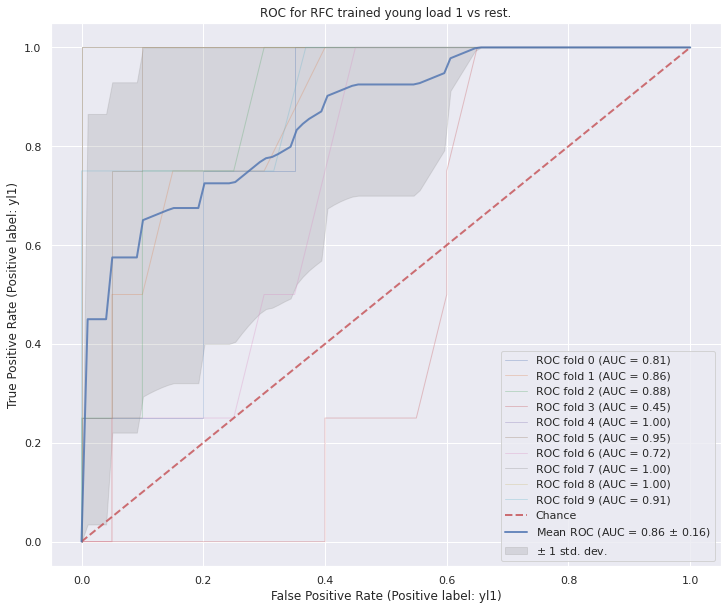

In [88]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "yl1"] = "yl1"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained young load 1 vs rest.")

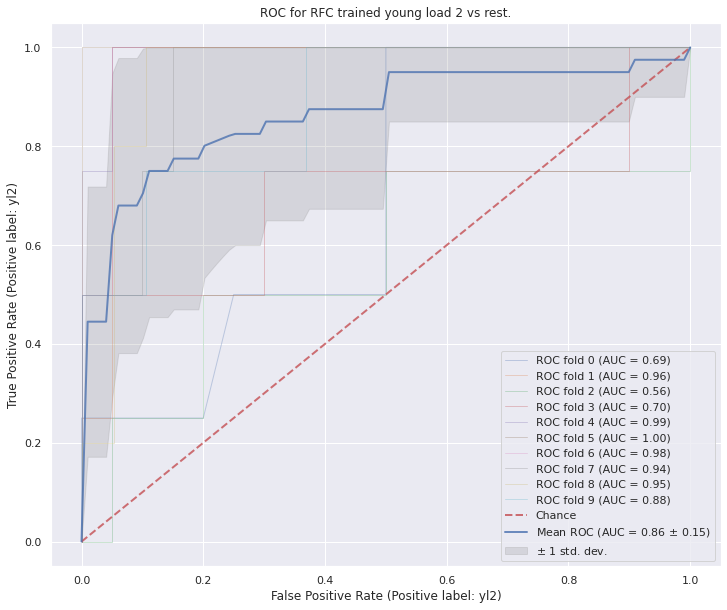

In [89]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "yl2"] = "yl2"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained young load 2 vs rest.")

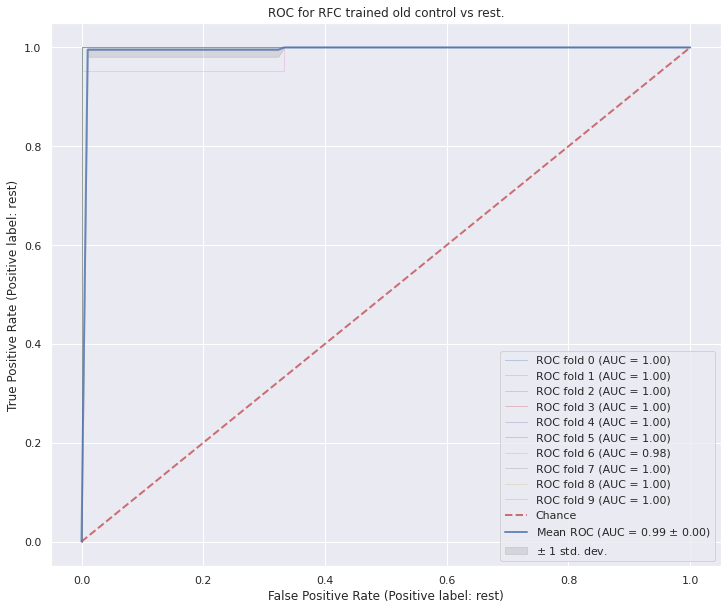

In [90]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "oc"] = "oc"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained old control vs rest.")

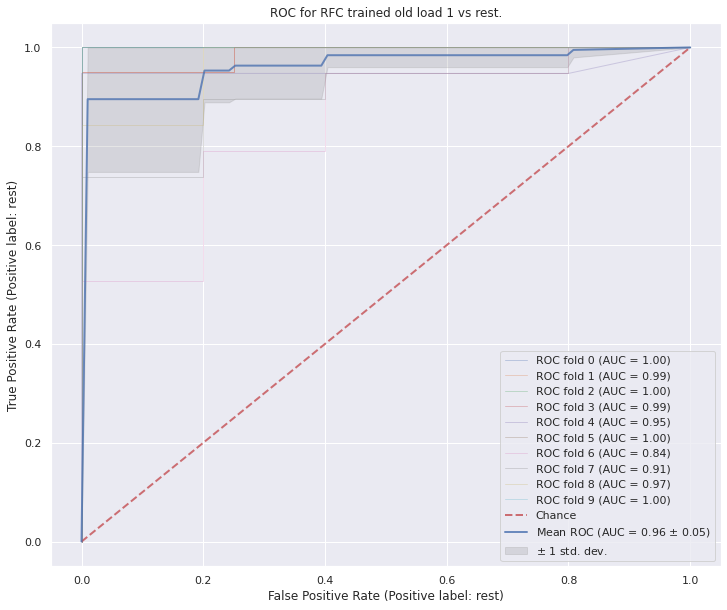

In [91]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "ol1"] = "ol1"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained old load 1 vs rest.")

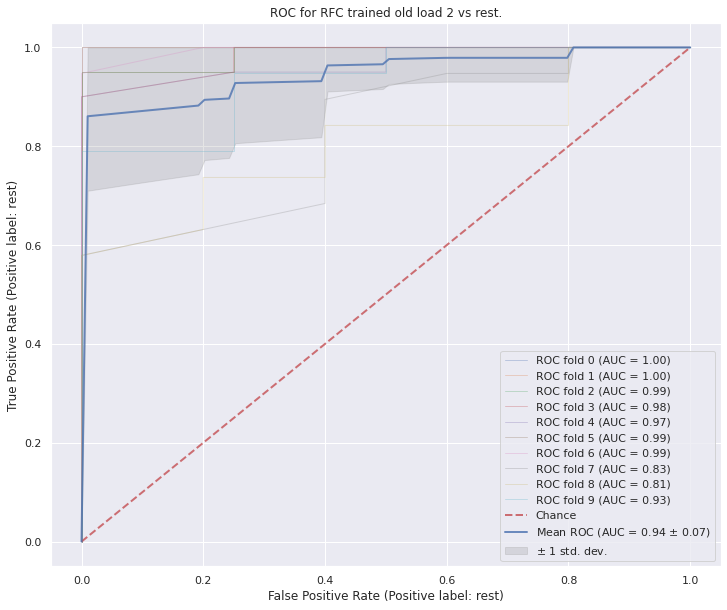

In [92]:
binarized_labels = np.repeat("rest", len(sample_labels))
binarized_labels[sample_labels == "ol2"] = "ol2"
_, _, fitted_rfc = plot_roc_for_stratified_cv(scaled_subset_all_features, binarized_labels, 10, rfc, "ROC for RFC trained old load 2 vs rest.")

We see that the model performs fairly good when trained to separate the nuclei from the control setting from all others respectively also the ones from the condition-media setting. Identifying samples from the TNFa treatment condition is substantially more difficult. 

#### 4.1.3. Confusion matrix

This fact is also reflected in the confusion matrix for a test dataset that we generate by holding out 50% of the data sampled in a stratified manner before training the model.

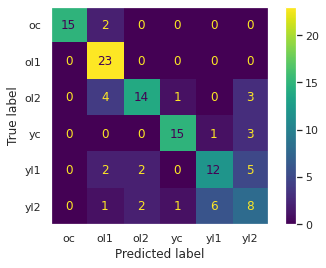

In [93]:
features_train, features_test, labels_train, labels_test = train_test_split(scaled_subset_all_features, sample_labels, 
                                                                             test_size=0.5, random_state=1234)
fitted_rfc = rfc.fit(features_train, labels_train)
disp = plot_confusion_matrix(rfc, features_test, labels_test)
plt.grid(b=None)
plt.show()

#### 4.1.4. Feature importance

Next, we will look at which features are the most discriminative between the classes in general. To this end we look at the feature importance of the RFC which we trained on 50% of the data.

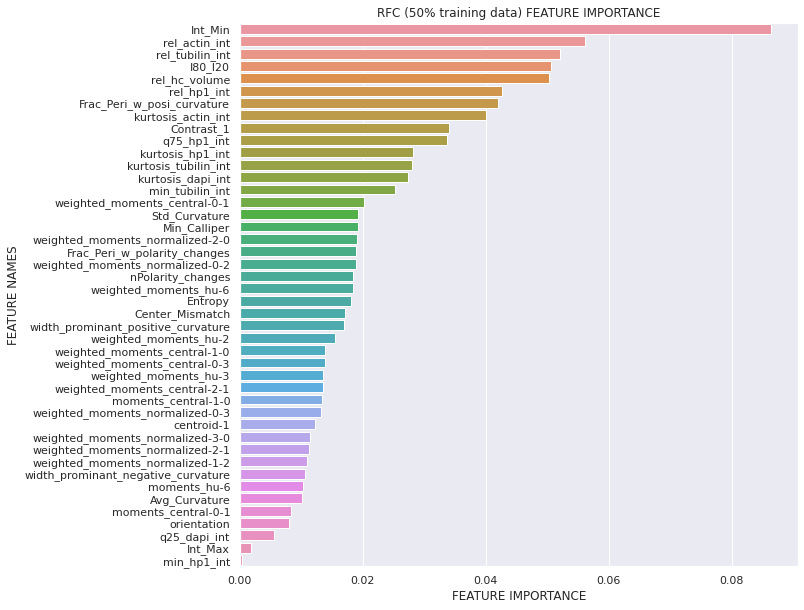

In [94]:
plot_feature_importance(fitted_rfc.feature_importances_, subset_all_features.columns, "RFC (50% training data) ")

The fact that the minimum DAPI intensity of the max-z projection of the nucleus is by far the most important one to discriminate between the classes is unexpected. Similarly, we find that the maximum HP1 intensity as well as the maxium DAPI intensity are among the five most important features to discriminate between these.

Since we do not have seen previously any strong batch-effects this unlikely a batch effect. To verify this - one would however rerun the analysis using two additional technical replicates.

### 4.2. Hypothesis testing

We will now test all of the 44 features we have left with respect to their significance in the differences between the the different experimental conditions using the Wilcoxon rank sum test.

#### 4.2.1. Control vs condition media

In [95]:
markers = find_markers(subset_all_features_w_sample)

In [96]:
sign_markers = markers.loc[markers.fwer_padj <0.0001].sort_values(["sample","abs_delta_fc"], ascending=False).groupby("sample").head(10)

In [97]:
sign_markers

,sample,marker,fc,abs_delta_fc,pval,fwer_padj
34,yl2,kurtosis_dapi_int,1.406665,0.406665,1.180022e-03,4.469781e-06
40,yl2,kurtosis_actin_int,1.316969,0.316969,7.783564e-05,2.948320e-07
6,yl2,Int_Min,0.732804,0.267196,6.786626e-12,2.570692e-14
39,yl2,rel_actin_int,1.247204,0.247204,5.769893e-04,2.185565e-06
10,yl2,Contrast_1,0.790243,0.209757,1.680868e-07,6.366925e-10
16,yl2,weighted_moments_normalized-2-0,1.174337,0.174337,5.741271e-03,2.174724e-05
5,yl2,Min_Calliper,1.114360,0.114360,9.431755e-04,3.572635e-06
2,yl2,nPolarity_changes,1.104068,0.104068,1.496213e-03,5.667474e-06
0,yl2,Avg_Curvature,0.904913,0.095087,7.410229e-03,2.806905e-05
8,yl2,Entropy,1.055585,0.055585,2.030425e-04,7.691003e-07
